# Forecasting using ARIMA and SARIMAX

We will solve this problem using ARIMA and SARIMA

ARIMA: Auto-Regressive Integrated moving averages

We need to do the following steps for any time series forecasting model:

- Visualise the data
- Make the time series stationary if it is not
- Plot the correlation and autocorrelation charts
- Construct the ARIMA or the SARIMA model based on the data
- Prepare the model to make predictions

We need to forecast the monthly champagne sales for this organization. 
The predicted period is open to be selected as per choice. I have taken three years from the last record

In [52]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [53]:
df = pd.read_excel('champagne.xlsx')
df.head()

,Month,Monthly_sales
0,1964-01-01,2815
1,1964-02-01,2672
2,1964-03-01,2755
3,1964-04-01,2721
4,1964-05-01,2946


In [54]:
df.tail()

,Month,Monthly_sales
100,1972-05-01,4618
101,1972-06-01,5312
102,1972-07-01,4298
103,1972-08-01,1413
104,1972-09-01,5877


In [55]:
# convert month to datetime format
df['Month'] = pd.to_datetime(df['Month'])
df.dtypes

Month            datetime64[ns]
Monthly_sales             int64
dtype: object

In [56]:
df.set_index('Month',inplace=True)
df.head()

,Monthly_sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


# Let's Visualise the data

In [57]:
# Running summary for df
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Monthly_sales,105.0,4761.152381,2553.502601,1413.0,3113.0,4217.0,5221.0,13916.0


<AxesSubplot:xlabel='Month'>

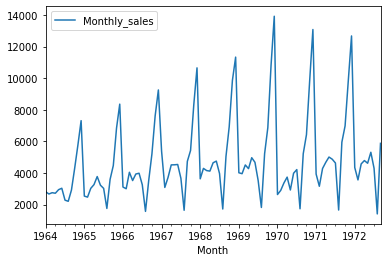

In [59]:
# let's check the seasonality
df.plot()

- The data looks seasonal - Lets check and confirm with dicky fuller test below:

In [60]:
# let's check the stationarity of the data
# we will use dicky fuller test for this
from statsmodels.tsa.stattools import adfuller
test_result = adfuller(df['Monthly_sales'])

In [61]:
#Dicky fuller test says:
#H0 - which means that the data is nonstationary
#H1 - the data is stationary
def ad_fuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#lags used','Observations used']
    for value, label in zip(result,labels):
        print(label + ' - '+ str(value))
    if result[1]<=0.05:
        print("Accept the alternate hypothesis as p value is <= 0.05. Data is stationary")
    else:
        print("Accept the Null hypothesis as p value is > 0.05. Data is non stationary")

In [62]:
ad_fuller_test(df['Monthly_sales'])

ADF Test Statistic - -1.8335930563276193
p-value - 0.36391577166024686
#lags used - 11
Observations used - 93
Accept the Null hypothesis as p value is > 0.05. Data is non stationary


In [63]:
# To overcome the problem of nonstationarity we need to make it stationary
# We have to do something called Differencing - Shifting just one position of the sales data
# But we need to see that the data given to us has yearly values in it. SO 12 months for each time period or we can say once the cycle is completed starting from. first month to the 12 months of each year
# Hence we will do a shift of 12 instead of just 1 month for our data

In [64]:
df['sales_difference'] = df['Monthly_sales'] - df['Monthly_sales'].shift(12)
df.head(13)

,Monthly_sales,sales_difference
Month,,
1964-01-01,2815,NaN
1964-02-01,2672,NaN
1964-03-01,2755,NaN
1964-04-01,2721,NaN
1964-05-01,2946,NaN
1964-06-01,3036,NaN
1964-07-01,2282,NaN
1964-08-01,2212,NaN
1964-09-01,2922,NaN


In [65]:
# now let's run the dicky fuller test again
#make sure to drop na before passing into our dicky fuller function
ad_fuller_test(df['sales_difference'].dropna())

ADF Test Statistic - -7.626619157213166
p-value - 2.0605796968136632e-11
#lags used - 0
Observations used - 92
Accept the alternate hypothesis as p value is <= 0.05. Data is stationary


In [66]:
# if p-value would be 0 then the below plot would have been completely stationary
#but still there is some variance in the below plot. but still, the data is stationary

<AxesSubplot:xlabel='Month'>

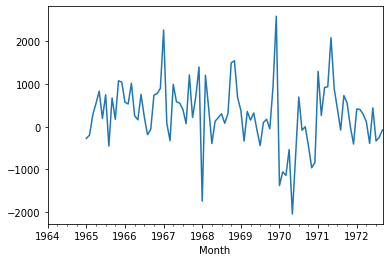

In [67]:
# now we can see that our time series is stationary
#lets plot and check
df['sales_difference'].plot()

# AutoRegressive Model

ACF
- The auto correlation at lag 1 is the correlation b/w corr(y(t),y(t-1)) for lag 2 corr(y(t),y(t-2)) etc..
- The bars below that lie b/w the blue shaded region are not statistically significant

PACF:
- is the correlation b/w the value of a time series and a lagged version of itself after we subtract the fact of correlation at smaller lags
So its a correlation associated with just a particular lag

<img src="acf-pacf1.png">

- from the above image we can say that when ACF tail offs at a certain level and PACF cutss after a certain lag then we have a AP model
- the above is a AR(2) model.. hence the value of p =2

<img src="acf-pacf2.png">

- from the above image we can say that when ACF cuts off after lag q and PACF tails off then we have a MA model
- The above shows that we have a MA(2) model. That means value of q=2

In [68]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

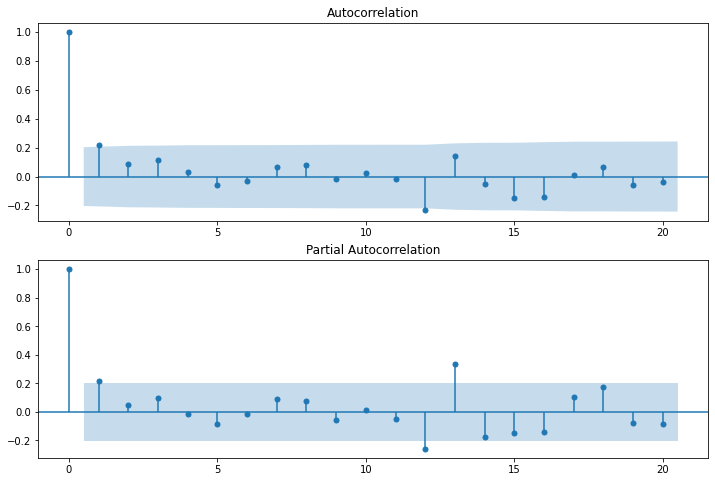

In [69]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['sales_difference'].dropna(),lags=20,ax=ax1) # top drop the first nan values from the series
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['sales_difference'].dropna(),lags=20,ax=ax2)

In [70]:
# Our data now is seasonal and for that ARIMA won't be the best method but we need to fit in SARIMA or SARIMAX
#from the above acf and pacf we have found that the values for the model are: p=1, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(df['Monthly_sales'],order=(1,1,1))
model_fit=model.fit()

/Users/ishanbabbar/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [71]:
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D.Monthly_sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.262
Date:                Thu, 04 Mar 2021   AIC                           1910.251
Time:                        23:39:00   BIC                           1920.829
Sample:                    02-01-1964   HQIC                          1914.536
                         - 09-01-1972                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    22.7850     12.405      1.837      0.069      -1.529      47.099
ar.L1.D.Monthly_sales     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.Monthly_sales    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='Month'>

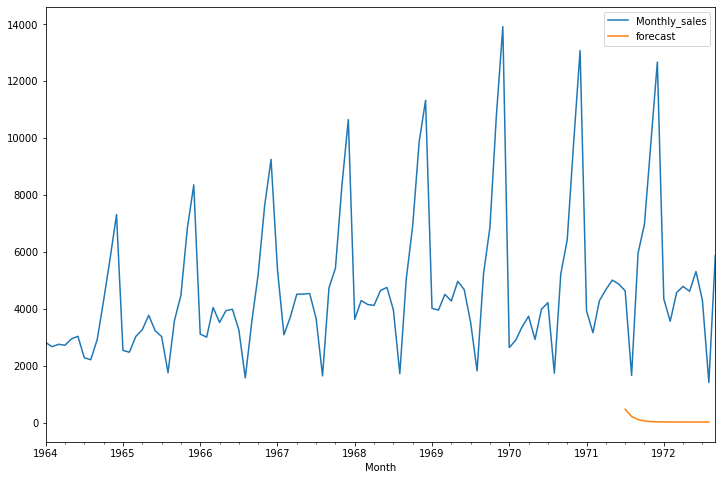

In [72]:
df['forecast']=model_fit.predict(start=90,end=103,dynamic=True) # I am just using the starting index and end index as the two values b/w which I want to see the forecast
df[['Monthly_sales','forecast']].plot(figsize=(12,8))

In [73]:
# from above we can see that the forecasting is really bad as expected with ARIMA
# Let's now apply SARIMA and see the difference
model_SARIMA=sm.tsa.statespace.SARIMAX(df['Monthly_sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12)) # 12 represents the total shift that we did before while calculating the difference
results=model_SARIMA.fit()

/Users/ishanbabbar/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [74]:
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                      Monthly_sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Thu, 04 Mar 2021   AIC                           1486.804
Time:                                    23:39:03   BIC                           1499.413
Sample:                                01-01-1964   HQIC                          1491.893
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043    -22.334      0.000      -1.033      -0.866
ar.S.L12      -0.4544      0.303     -1.499      0.134      -1.049       0.140
ma.S.L12       0.2450      0.311      0.788      0.431      -0.365       0.855
sigma2      5.055e+05   6.12e+04      8.265      0.000    3.86e+05    6.25e+05
===================================================================================
Ljung-Box (Q):                       40.24   Jarque-Bera (JB):                 8.70
Prob(Q):                              0.46   Prob(JB):                         0.01
Heteroskedasticity (H):               1.18   Skew:                            -0.21
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Month'>

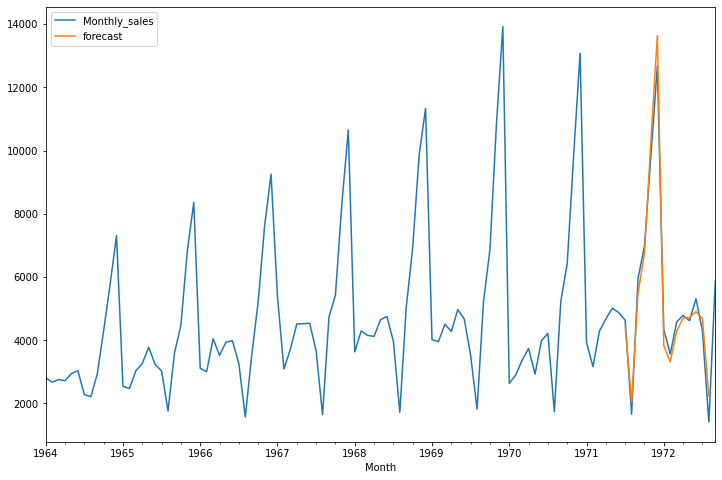

In [75]:
df['forecast']=results.predict(start=90,end=103,dynamic=True)# I am just using the starting index and end index as the two values b/w which I want to see the forecast
df[['Monthly_sales','forecast']].plot(figsize=(12,8))

In [76]:
# Now the forecast looks pretty great.
# let's use some future dummy dates values from the pandas library and plot the forecast for them

In [77]:
# we are taking here two years
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,36)]

In [78]:
future_dates

[Timestamp('1972-09-01 00:00:00'),
 Timestamp('1972-10-01 00:00:00'),
 Timestamp('1972-11-01 00:00:00'),
 Timestamp('1972-12-01 00:00:00'),
 Timestamp('1973-01-01 00:00:00'),
 Timestamp('1973-02-01 00:00:00'),
 Timestamp('1973-03-01 00:00:00'),
 Timestamp('1973-04-01 00:00:00'),
 Timestamp('1973-05-01 00:00:00'),
 Timestamp('1973-06-01 00:00:00'),
 Timestamp('1973-07-01 00:00:00'),
 Timestamp('1973-08-01 00:00:00'),
 Timestamp('1973-09-01 00:00:00'),
 Timestamp('1973-10-01 00:00:00'),
 Timestamp('1973-11-01 00:00:00'),
 Timestamp('1973-12-01 00:00:00'),
 Timestamp('1974-01-01 00:00:00'),
 Timestamp('1974-02-01 00:00:00'),
 Timestamp('1974-03-01 00:00:00'),
 Timestamp('1974-04-01 00:00:00'),
 Timestamp('1974-05-01 00:00:00'),
 Timestamp('1974-06-01 00:00:00'),
 Timestamp('1974-07-01 00:00:00'),
 Timestamp('1974-08-01 00:00:00'),
 Timestamp('1974-09-01 00:00:00'),
 Timestamp('1974-10-01 00:00:00'),
 Timestamp('1974-11-01 00:00:00'),
 Timestamp('1974-12-01 00:00:00'),
 Timestamp('1975-01-

In [79]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)


In [80]:
#concatenate it with the original data set
future_df=pd.concat([df,future_datest_df])


In [81]:
future_df.tail()

,Monthly_sales,sales_difference,forecast
1975-04-01,NaN,NaN,NaN
1975-05-01,NaN,NaN,NaN
1975-06-01,NaN,NaN,NaN
1975-07-01,NaN,NaN,NaN
1975-08-01,NaN,NaN,NaN


<AxesSubplot:>

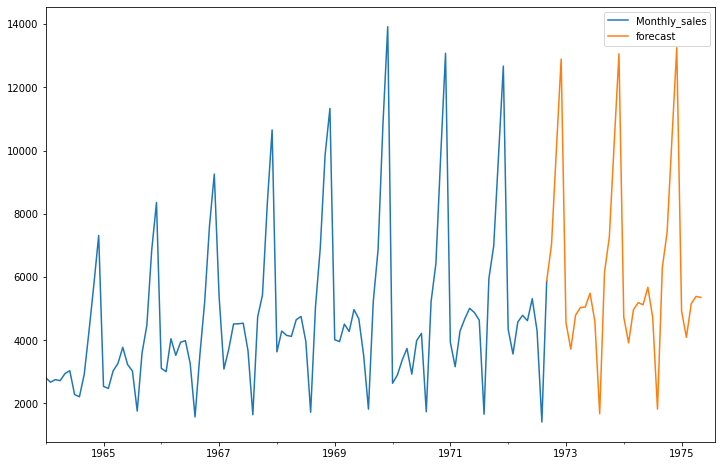

In [84]:
future_df['forecast'] = results.predict(start = 104, end = 136, dynamic= True)  
future_df[['Monthly_sales', 'forecast']].plot(figsize=(12, 8))

In [ ]:
# Now we can see from above that how the forecasts looks like! Pretty Neat! 